<a href="https://colab.research.google.com/github/gustavoteixeirah/trabalho-tmci/blob/main/vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformadores de Visão de Ajuste Fino para Classificação de Imagens

Assim como os modelos baseados em transformadores revolucionaram a PNL, agora estamos vendo uma explosão de artigos aplicando-os a todos os tipos de outros domínios. Um dos mais revolucionários deles foi o Vision Transformer (ViT), que foi introduzido em [junho de 2021](https://arxiv.org/abs/2010.11929) por uma equipe de pesquisadores do Google Brain.

Este artigo explorou como você pode tokenizar imagens, assim como tokenizaria frases, para que elas possam ser passadas para modelos de transformadores para treinamento. É um conceito bem simples, na verdade...

1. Dividir uma imagem em uma grade de patches de subimagem
1. Incorpore cada patch com uma projeção linear
1. Cada patch incorporado se torna um token, e a sequência resultante de patches incorporados é a sequência que você passa para o modelo.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

Acontece que, depois de fazer o acima, você pode pré-treinar e ajustar os transformadores exatamente como está acostumado com tarefas de NLP. Muito legal 😎.

---

Neste notebook, mostraremos como aproveitar 🤗 `datasets` para baixar e processar conjuntos de dados de classificação de imagens e, em seguida, usá-los para ajustar um ViT pré-treinado com 🤗 `transformers`.

Para começar, vamos primeiro instalar esses dois pacotes.

In [3]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

## Load a dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import files
import zipfile
import os


# Extrair o arquivo zip
with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall('datasets')

# Listar os arquivos extraídos
os.listdir('datasets')

['cats_and_dogs_filtered']

Vamos começar carregando um pequeno conjunto de dados de classificação de imagens e dando uma olhada em sua estrutura.

Usaremos o conjunto de dados [`beans`](https://huggingface.co/datasets/beans), que é uma coleção de fotos de folhas de feijão saudáveis ​​e doentes. 🍃



In [6]:
from datasets import Dataset, DatasetDict, ClassLabel, Features, Value, Image
from PIL import Image as PILImage

import os

def create_dataset_from_directory(base_path):
    images = []
    labels = []
    label_names = ['cats', 'dogs']
    examples = []

    for label_id, label in enumerate(label_names):
        img_dir = os.path.join(base_path, label)
        for img_file in os.listdir(img_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(img_dir, img_file)
                image = PILImage.open(img_path).convert('RGB')
                images.append(image)
                labels.append(label_id)
                examples.append({
                    'image': image,
                    'labels': label_id,
                    'image_file_path': img_path
                })
    dataset_dict = {
        'image': [ex['image'] for ex in examples],
        'labels': [ex['labels'] for ex in examples],
        'image_file_path': [ex['image_file_path'] for ex in examples]
    }

    features = Features({
        'image': Image(),
        'labels': ClassLabel(names=['cats', 'dogs']),
        'image_file_path': Value('string')
    })

    return Dataset.from_dict(dataset_dict, features=features)

PATH = os.path.join(os.path.dirname('./'), 'datasets/cats_and_dogs_filtered')

ds = DatasetDict({
    'train': create_dataset_from_directory(os.path.join(PATH, 'train')),
    'validation': create_dataset_from_directory(os.path.join(PATH, 'validation'))
})

Vamos dar uma olhada no 400º exemplo da divisão `'train'` do conjunto de dados beans. Você notará que cada exemplo do conjunto de dados tem 3 recursos:

1. `image`: Uma imagem PIL
1. `image_file_path`: O caminho `str` para o arquivo de imagem que foi carregado como `image`
1. `labels`: Um recurso [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel), que veremos como uma representação inteira do rótulo para um determinado exemplo. (Mais tarde, veremos como obter os nomes das classes de string, não se preocupe)

In [7]:
ex = ds['train'][400]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=499x375>,
 'labels': 0,
 'image_file_path': './datasets/cats_and_dogs_filtered/train/cats/cat.246.jpg'}

Vamos dar uma olhada na imagem 👀

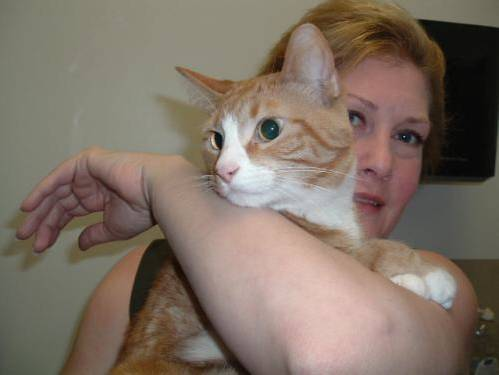

In [8]:
image = ex['image']
image

Definitivamente é uma folha! Mas que tipo? 😅

Como o recurso `'labels'` deste conjunto de dados é um `datasets.features.ClassLabel`, podemos usá-lo para procurar o nome correspondente para o ID do rótulo deste exemplo.

Primeiro, vamos acessar a definição do recurso para `'labels'`.

In [9]:
labels = ds['train'].features['labels']
labels

ClassLabel(names=['cats', 'dogs'], id=None)

Agora, vamos imprimir o rótulo da classe para nosso exemplo. Faremos isso usando a função [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) de `ClassLabel`, que, como o nome indica, nos permite passar a representação int da classe para procurar o rótulo da string.

In [10]:
labels.int2str(ex['labels'])

'cats'

Acontece que a folha mostrada acima está infectada com ferrugem do feijão, uma doença séria em plantas de feijão. 😢

Vamos escrever uma função que exibirá uma grade de exemplos de cada classe para que possamos ter uma ideia melhor do que estamos trabalhando.

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

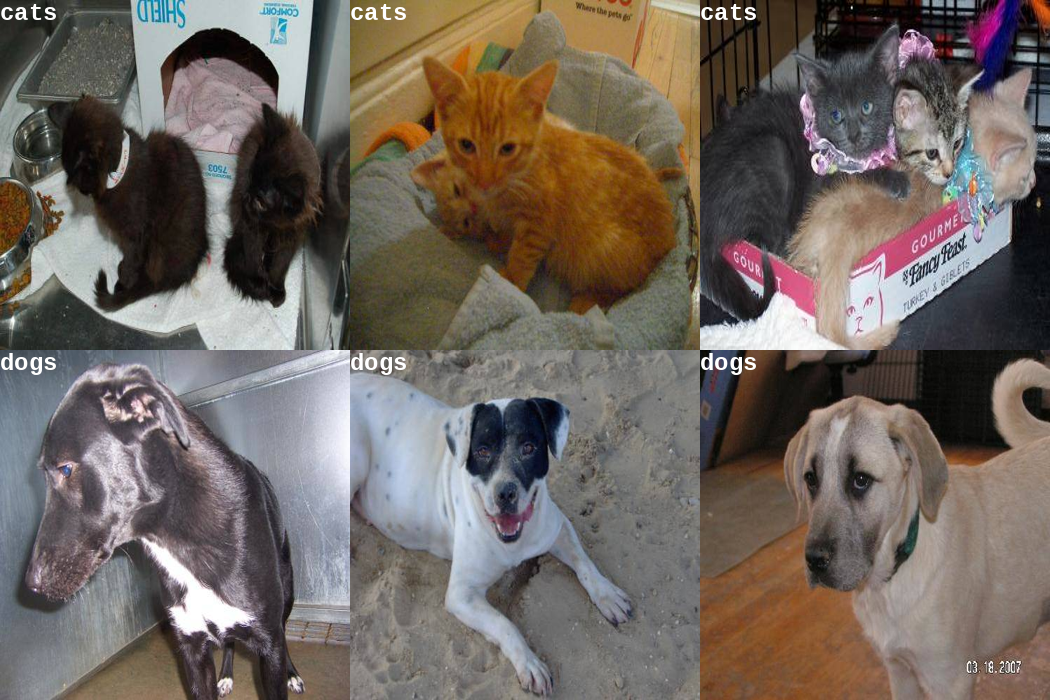

In [11]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

Pelo que estou vendo,
- Mancha Angular da Folha: Tem manchas marrons irregulares
- Ferrugem do Feijão: Tem manchas marrons circulares cercadas por um anel amarelo-esbranquiçado
- Saudável: ...parece saudável. 🤷‍♂️

## Carregando o ViT Feature Extractor

Agora que sabemos como são nossas imagens e temos uma melhor compreensão do problema que estamos tentando resolver, vamos ver como podemos preparar essas imagens para nosso modelo.

Quando os modelos ViT são treinados, transformações específicas são aplicadas às imagens que estão sendo alimentadas neles. Use as transformações erradas em sua imagem e o modelo não será capaz de entender o que está vendo! 🖼 ➡️ 🔢

Para garantir que aplicamos as transformações corretas, usaremos um [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) inicializado com uma configuração que foi salva junto com o modelo pré-treinado que planejamos usar. No nosso caso, usaremos o modelo [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k), então vamos carregar seu extrator de recursos do 🤗 Hub.

In [12]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Se imprimirmos um extrator de recursos, poderemos ver sua configuração.

In [13]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Para processar uma imagem, basta passá-la para a função call do extrator de recursos. Isso retornará um dict contendo `pixel values`, que é a representação numérica da sua imagem que passaremos para o modelo.

Obtemos um array numpy por padrão, mas se adicionarmos o argumento `return_tensors='pt'`, obteremos tensores `torch` em vez disso.


In [14]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-0.1137, -0.1059, -0.0980,  ..., -0.1608, -0.1765, -0.1843],
          [-0.1137, -0.1059, -0.0980,  ..., -0.1608, -0.1686, -0.1686],
          [-0.1137, -0.1059, -0.0980,  ..., -0.1608, -0.1686, -0.1608],
          ...,
          [-0.4431, -0.4196, -0.4118,  ..., -0.6078, -0.5843, -0.5765],
          [-0.4431, -0.4196, -0.4118,  ..., -0.6314, -0.6157, -0.6078],
          [-0.4431, -0.4196, -0.4118,  ..., -0.6471, -0.6157, -0.5922]],

         [[-0.1059, -0.0980, -0.0902,  ..., -0.1843, -0.2000, -0.2078],
          [-0.1059, -0.0980, -0.0902,  ..., -0.1843, -0.1922, -0.1922],
          [-0.1059, -0.0980, -0.0902,  ..., -0.1843, -0.1922, -0.1843],
          ...,
          [-0.3961, -0.3725, -0.3647,  ..., -0.6000, -0.5922, -0.6078],
          [-0.3961, -0.3725, -0.3647,  ..., -0.6235, -0.6235, -0.6392],
          [-0.3961, -0.3725, -0.3647,  ..., -0.6392, -0.6235, -0.6235]],

         [[-0.2157, -0.2078, -0.2000,  ..., -0.3176, -0.3333, -0.3412],
          [-0

## Processando o conjunto de dados

Agora que sabemos como ler imagens e transformá-las em entradas, vamos escrever uma função que juntará essas duas coisas para processar um único exemplo do conjunto de dados.

In [15]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [16]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[-0.4510, -0.4431, -0.4824,  ..., -0.2235, -0.2235, -0.2314],
          [-0.4588, -0.4353, -0.4667,  ..., -0.2078, -0.2157, -0.2157],
          [-0.4353, -0.4196, -0.4745,  ..., -0.2000, -0.2078, -0.2078],
          ...,
          [-0.9137, -0.8510, -0.8275,  ..., -0.4980, -0.4980, -0.4980],
          [-0.8667, -0.8118, -0.8196,  ..., -0.4980, -0.4980, -0.4980],
          [-0.8353, -0.8275, -0.8353,  ..., -0.4980, -0.4980, -0.4980]],

         [[-0.6078, -0.5765, -0.5843,  ..., -0.2549, -0.2549, -0.2627],
          [-0.6235, -0.5765, -0.5765,  ..., -0.2392, -0.2471, -0.2471],
          [-0.6157, -0.5686, -0.5843,  ..., -0.2314, -0.2392, -0.2392],
          ...,
          [-0.6392, -0.5765, -0.5529,  ..., -0.5451, -0.5451, -0.5451],
          [-0.5922, -0.5373, -0.5451,  ..., -0.5451, -0.5451, -0.5451],
          [-0.5608, -0.5529, -0.5608,  ..., -0.5451, -0.5451, -0.5451]],

         [[-0.7961, -0.7961, -0.8118,  ..., -0.3490, -0.3490, -0.3569],
          [-0

Embora pudéssemos chamar `ds.map` e aplicar isso a todos os exemplos de uma vez, isso pode ser muito lento, especialmente se você usar um conjunto de dados maior. Em vez disso, aplicaremos uma ***transform*** ao conjunto de dados. As transformações são aplicadas apenas aos exemplos conforme você os indexa.

Primeiro, porém, precisaremos atualizar nossa última função para aceitar um lote de dados, pois é isso que `ds.with_transform` espera.

In [17]:


def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

Podemos aplicar isso diretamente ao nosso conjunto de dados usando ds.with_transform(transform).

In [18]:
prepared_ds = ds.with_transform(transform)

Agora, sempre que obtivermos um exemplo do conjunto de dados, nossa transformação será
aplicada em tempo real (em amostras e fatias, conforme mostrado abaixo)

In [19]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-0.4510, -0.4431, -0.4824,  ..., -0.2235, -0.2235, -0.2314],
          [-0.4588, -0.4353, -0.4667,  ..., -0.2078, -0.2157, -0.2157],
          [-0.4353, -0.4196, -0.4745,  ..., -0.2000, -0.2078, -0.2078],
          ...,
          [-0.9137, -0.8510, -0.8275,  ..., -0.4980, -0.4980, -0.4980],
          [-0.8667, -0.8118, -0.8196,  ..., -0.4980, -0.4980, -0.4980],
          [-0.8353, -0.8275, -0.8353,  ..., -0.4980, -0.4980, -0.4980]],

         [[-0.6078, -0.5765, -0.5843,  ..., -0.2549, -0.2549, -0.2627],
          [-0.6235, -0.5765, -0.5765,  ..., -0.2392, -0.2471, -0.2471],
          [-0.6157, -0.5686, -0.5843,  ..., -0.2314, -0.2392, -0.2392],
          ...,
          [-0.6392, -0.5765, -0.5529,  ..., -0.5451, -0.5451, -0.5451],
          [-0.5922, -0.5373, -0.5451,  ..., -0.5451, -0.5451, -0.5451],
          [-0.5608, -0.5529, -0.5608,  ..., -0.5451, -0.5451, -0.5451]],

         [[-0.7961, -0.7961, -0.8118,  ..., -0.3490, -0.3490, -0.3569],
          [-0

# Treinamento e Avaliação

Os dados são processados ​​e estamos prontos para começar a configurar o pipeline de treinamento. Usaremos o Trainer do 🤗, mas isso exigirá que façamos algumas coisas primeiro:

- Definir uma função collate.

- Definir uma métrica de avaliação. Durante o treinamento, o modelo deve ser avaliado em sua precisão de previsão. Devemos definir uma função compute_metrics adequadamente.

- Carregar um ponto de verificação pré-treinado. Precisamos carregar um ponto de verificação pré-treinado e configurá-lo corretamente para o treinamento.

- Definir a configuração de treinamento.

Depois de ajustar o modelo, avaliaremos corretamente os dados de avaliação e verificaremos se ele realmente aprendeu a classificar corretamente nossas imagens.

### Defina nosso coletor de dados

Os lotes estão chegando como listas de dicts, então nós apenas descompactamos + empilhamos esses em tensores de lote.

Retornamos um `dict` de lote do nosso `collate_fn` para que possamos simplesmente `**descompactar` as entradas para o nosso modelo mais tarde. ✨

In [20]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Defina uma métrica de avaliação

Aqui, carregamos a métrica [accuracy](https://huggingface.co/metrics/accuracy) de `datasets` e, em seguida, escrevemos uma função que recebe uma previsão do modelo + calcula a precisão.

In [21]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00


In [22]:
import numpy as np
import evaluate  # Nova biblioteca

# Carrega a métrica de acurácia
metric = evaluate.load("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Agora podemos carregar nosso modelo pré-treinado. Adicionaremos `num_labels` no init para garantir que o modelo crie um cabeçalho de classificação com o número certo de unidades. Também incluiremos os mapeamentos `id2label` e `label2id` para que tenhamos rótulos legíveis por humanos no widget do hub 🤗 se escolhermos `push_to_hub`.

In [23]:
from transformers import ViTForImageClassification

labels = ds['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Estamos quase prontos para treinar! A última coisa que faremos antes disso é configurar o treinamento definindo [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

A maioria deles é bem autoexplicativa, mas um que é bem importante aqui é `remove_unused_columns=False`. Este removerá quaisquer recursos não usados ​​pela função de chamada do modelo. Por padrão, é `True` porque geralmente é ideal remover colunas de recursos não usadas, pois isso torna mais fácil descompactar entradas na função de chamada do modelo. Mas, no nosso caso, precisamos dos recursos não usados ​​('image' em particular) para criar 'pixel_values'.

O que estou tentando dizer é que você terá problemas se esquecer de definir `remove_unused_columns=False`.

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Agora, todas as instâncias podem ser passadas para o Trainer e estamos prontos para começar o treinamento!



In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

<ipython-input-25-966ff6ab886d>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.112600,0.068874,0.978000
200,0.011000,0.035736,0.990000
300,0.003600,0.054141,0.989000
400,0.001800,0.044739,0.991000
500,0.001600,0.044684,0.991000


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 577360314GF
  train_loss               =      0.0407
  train_runtime            =  0:04:42.05
  train_samples_per_second =      28.364
  train_steps_per_second   =       1.773


In [27]:
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =       0.99
  eval_loss               =     0.0357
  eval_runtime            = 0:00:23.41
  eval_samples_per_second =     42.707
  eval_steps_per_second   =      5.338


In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'beans',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

O modelo resultante foi compartilhado em [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans). Estou supondo que você não tenha fotos de folhas de feijão por aí, mas se tiver, você pode testar o modelo no navegador 🚀.